# CDR Experiments via Pymagicc
##### CC-BY 4.0 2020 @safiume
#### https://github.com/hsbay/cdrmex

In [1]:
# NBVAL_IGNORE_OUTPUT
import sys, re
from os import listdir
from os.path import join, dirname
from pprint import pprint
import expectexception
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline
import f90nml

In [2]:
#Disable warning supression if running locally
import warnings
warnings.simplefilter("ignore", category=Warning, lineno=0, append=False)

In [3]:
import pymagicc
from pymagicc import MAGICC6
from pymagicc.io import MAGICCData, read_cfg_file, NoReaderWriterError
from pymagicc.scenarios import ( rcp26, rcp45, zero_emissions )
from scmdata import run_append
print(pymagicc.__version__)
print(sys.version)
rcp26.__class__.__bases__

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


2.0.0rc8+19.g7aade1e.dirty
3.7.4 (v3.7.4:e09359112e, Jul  8 2019, 14:54:52) 
[Clang 6.0 (clang-600.0.57)]


(scmdata.run.ScmRun,)

In [4]:
pd.set_option("precision", 4)
## List of experiments in declines
declines = ["emax", "lmax", "emin", "lmin"]
SCEN_DIR = "SCEN"
MAGICC6_DIR = join("..", "CDRRUN")

# Net Zero Start Year
nzst = 2029

# Start MAGICC at 1720 or before
# The baseline for 0 °C will be recalculated based the mean
# temp for 1720-1800.
## Start of MAGICC settings
magcfg = {'startyear' : 1850,
          'endyear' : 2500,
          'core_climatesensitivity' : 2.6,             #BERN
          #'co2_tempfeedback_yrstart' : 2005,
          #'co2_fertilization_yrstart' : 2005,
          'co2_switchfromconc2emis_year' : 2005,
          'rf_total_constantafteryr' : 2350,
          'rf_tropoz_constantafteryr' : 2350,
          'rf_stratoz_constantafteryr' : 2350,
          'rf_mhalo_constantafteryr' : 2150,
          'rf_fgas_constantafteryr' : 2150,
          'n2o_switchfromconc2emis_year': 2005,
          'fgas_switchfromconc2emis_year': 2005,
          'mhalo_switchfromconc2emis_year' : 2008,
          'mhalo_switch_conc2emis_yr' : 2008,
          'out_forcing' : 1,
          'out_emissions' : 1,
          'out_concentrations' : 1,
          'out_temperature' : 1,
          'out_warnings': 1,
          'out_misc': 1,
         }
### End MAGICC Settings

Import IMAGE-SSP1-1.9 from manually imported SCEN built from 
"IMAGE 3.0.1","SSP1-19","World","Diagnostics|MAGICC6|Harmonized Input|*

© IAMC 1.5°C Scenario Explorer hosted by IIASA https://data.ene.iiasa.ac.at/iamc-1.5c-explorer

There are some artifacts in the dataset and subsequent graphs as the download was missing the full fgasses and halo gasses.

In [5]:
# Reassign startyear to include the year 1720.
graphstart = magcfg['startyear']
if magcfg['startyear'] > 1720:
    magcfg['startyear'] = 1720

## load experiments scen file data
for n, name in enumerate (declines):
    declinefile = join(SCEN_DIR, "ONC" + name + ".SCEN")
    declines[n] = MAGICCData(declinefile,
                             columns={"model": ["CDRex"], "scenario": [name]})

img119 = MAGICCData(join(SCEN_DIR, 'imgs119.SCEN'), 
                    columns={"model": ["IMAGE"], "scenario": ['SSP119']}, inplace=True)
declines.append(img119)

# Copy lmin data into new experiment
CCCx2050 = declines[3]
CCC_df = CCCx2050.timeseries()
CCC_df = CCC_df.rename(index={"lmin":"CCCx2050"})

In [6]:
declines[2].timeseries().head(3)
CCC_df.loc[:,datetime(2005,1,1,0):datetime(2030,1,1,0)].style

In [7]:
def interpt(start,end,length):
    start = float(start)
    end = float(end)
    length = int(length)  
    array = np.linspace(0, length, length+1)
    array = np.interp(array,[0,length],[start,end])
    return array

In [8]:
# Calculate how much carbon to remove to achieve 300 ppm at 2050
CRsyr = 2021
Bkyr = 2050
# CO₂ gas is in GtC (2020 AnthroFF+LUC-IMB)
AnthroC = 452
LuC = 200
# remainder after 300 ppm
CCCxFF = 202.00
CCCxLuC = 102.00

In [9]:
ki_mo_ghgs_F = [ 'HFC134a', 'HFC245fa', 'HFC227ea', 'HFC4310', 'HFC32', 'HFC125', 'HFC143a', 'HFC23' ]
broken_Fghgs = ['N2O', 'CF4', 'C2F6', 'C6F14', 'HFC143a', 'SF6']

#Inc Kigali/MontrealP GhG years
timepts = {
    'kigyr1' : [2019, .998],
    'pkyr' : [(CRsyr - 1), 1],
    'kigyr2' : [2024, .95], 
    'kigyr3' : [2025, .65],
    'kigyr4' : [2029, .30],
    'kigyr5' : [2034, .20],
    'sf6eu' : [2030, .30],
    'kigyr6' : [2036, .15],
    'edyr' : [2100, 0.00]
}
timepts.update({ 'CRsyr': [CRsyr, .97 ], 'Bkyr': [Bkyr, 0] })
timepts = pd.DataFrame(timepts,['year','NtZeroPcnt']).T
timepts = timepts.sort_values(by='year')
#Net Zero Dates - zero emissions for non CO2 gasses
n0dates = [nzst, 2100]

# harmonize to GCB(2020) FF+luc Ghg
# https://doi.org/10.18160/GCP-2020
# [2010-2020]
FF=[9.04, 9.34, 9.49, 9.55, 9.62, 9.61, 9.61, 9.74, 9.94, 9.95, 9.3]
# 2005, [2010-2020]
luc=[1.42, 1.46, 1.38, 1.49, 1.53, 1.65, 1.70, 1.56, 1.52, 1.55, 1.80, 1.6]

In [10]:
ems_ff = 'Emissions|CO2|MAGICC Fossil and Industrial'
ems_luc = 'Emissions|CO2|MAGICC AFOLU'
methane = 'Emissions|CH4'
emsf = ('unspecified','CDRex','World','CCCx2050','SET','Gt C / yr', ems_ff)
emsluc = ('unspecified','CDRex','World','CCCx2050','SET','Gt C / yr', ems_luc)

In [11]:
def dtspn(emm,dates,vals,df):
    if type(emm) == str:
        ndf = df.xs(emm, level = 'variable', drop_level = False)
    else :
        ndf = df.loc[:,:,:,:,:,:,emm]
    row = ndf.index.values
    ndf.at[row, datetime(dates[0],1,1) : datetime(dates[1],1,1)] = vals
    df.loc[ndf.index.values] = ndf 
    return df

def kigali(ki_ghgs,df):
    kgfs = []
    for kgs in ki_ghgs:
        kgs = ('Emissions|') + kgs
        kgfs.append(kgs)
    ndf = df.loc[:,:,:,:,:,:,kgfs]
    row = ndf.index.values
    mxyr = int(timepts.loc['pkyr'][0])    
    for i, tmpt in enumerate(timepts['year']):
        if tmpt < (timepts['year'].max()):
            tmpt = int(tmpt)
            nxtyr = int(timepts.iloc[[i+1],0])
            rate = timepts.iloc[[i],1].values
            rates = ndf.loc[:, datetime(mxyr,1,1,0)] * rate
            srws = ndf.loc[row, datetime(tmpt,1,1,0) : datetime(nxtyr,1,1,0)]
            srws.apply(lambda x: x * rates.values)
    df.loc[row] = ndf
    return df

def decline(ems, dates, xrate, df):
    ndf = df.xs(ems, level = 'variable', drop_level = False)
    row = ndf.index.values
    slc = ndf.loc[row, datetime(dates[0],1,1):datetime(dates[1],1,1)]
    slc.apply(lambda x: x * xrate)
    df.loc[ndf.index.values] = ndf
    return df


df = CCC_df.copy()
dates = [2010, 2020]
df = dtspn( ems_ff, dates, FF, df)
dates = [2005, 2020]
df = dtspn( ems_luc, dates, luc, df)
df = kigali(ki_mo_ghgs_F, df)
xrate = -0.336
dates = [2020, 2049]
df = decline(methane, dates, xrate, df)
# strip CO₂ FF, Luc, NH3 from index.values, broken_Fghgs, kigali
net0 = df.index.get_level_values(6)[[2,4,5,6,7,8,9]]
val = (0)
df = dtspn( net0, n0dates, val, df)
bkn0 = df.index.get_level_values(6)[[3,11,12,13,19,22]]
bkval = (-90)
dts = [nzst, nzst+1]
df = dtspn( bkn0, dts, bkval, df)
bkval = (0)
dts = [nzst+2, 2100]
df = dtspn( bkn0, dts, bkval, df)

CCC_df = df.copy()

#df #print copy for diags
#df.loc[:,datetime(2005,1,1,0):datetime(2035,1,1,0)].style

In [12]:
LuC_2050 = LuC - CCCxLuC
landsnk_yrly = LuC_2050/((Bkyr) - CRsyr)
landsnc_remainingYr = CCCxLuC/(2100 - Bkyr)

AC_2050 = AnthroC - CCCxFF
Peak_to_bk_yr = AC_2050/((Bkyr) - CRsyr)
Remaining_per_yr = CCCxFF/(2100 - Bkyr)

# Set removal according to forumlas in previous cell
CCC_df.loc[emsluc, datetime(2025,1,1) : datetime(2049,1,1)] = -landsnk_yrly
CCC_df.loc[emsluc, datetime(2050,1,1) : datetime(2099,1,1)] = -landsnc_remainingYr
CCC_df.loc[emsf, datetime(2025,1,1) : datetime(2049,1,1)] = -Peak_to_bk_yr
CCC_df.loc[emsf, datetime(2050,1,1) : datetime(2099,1,1)] = -Remaining_per_yr

In [13]:
# Zero out data past 2100 
CCC_df.loc[emsf, datetime(2100,1,1,0) : datetime(2150,1,1,0)] = 0
CCC_df.loc[emsluc, datetime(2100,1,1,0) : datetime(2150,1,1,0)] = 0

In [14]:
# Rewrite CCCx2050 from timeseries and wrap in MAGICCData
CCCx2050 = MAGICCData(CCC_df.copy())
CCCx2050.write(join(SCEN_DIR,'CCCx2050.SCEN'),magicc_version=6)
#CCC_df.to_csv('CCCx2050.csv')

CCC_flat = CCC_df.copy()
CCC_flat.loc[emsf, datetime(2051,1,1,0) : datetime(2150,1,1,0)] = 0
CCC_flat.loc[emsluc, datetime(2051,1,1,0) : datetime(2150,1,1,0)] = 0
CCC_flat = CCC_flat.rename(index={"CCCx2050":"CCCxflat"})
CCCxflat = MAGICCData(CCC_flat.copy())

In [15]:
print("Diagnostic Output")
print(CCC_df.head(2).iloc[:,[10]])
print(CCC_df.head(2).iloc[:,[32]])
print(CCC_df.head(2).iloc[:,[42]])
CCCx2050.timeseries().loc[:,datetime(2020,1,1,0) : datetime(2031,1,1,0)].head(23)

Diagnostic Output
time                                                                                           2019-01-01
climate_model model region scenario todo unit      variable                                              
unspecified   CDRex World  CCCx2050 SET  Gt C / yr Emissions|CO2|MAGICC Fossil and Industrial        9.95
                                                   Emissions|CO2|MAGICC AFOLU                        1.80
time                                                                                           2041-01-01
climate_model model region scenario todo unit      variable                                              
unspecified   CDRex World  CCCx2050 SET  Gt C / yr Emissions|CO2|MAGICC Fossil and Industrial     -8.6207
                                                   Emissions|CO2|MAGICC AFOLU                     -3.3793
time                                                                                           2051-01-01
climate_model model region s

time                                                                                                  2020-01-01  \
climate_model model region scenario todo unit             variable                                                 
unspecified   CDRex World  CCCx2050 SET  Gt C / yr        Emissions|CO2|MAGICC Fossil and Industrial      9.3000   
                                                          Emissions|CO2|MAGICC AFOLU                      1.6000   
                                         Mt CH4 / yr      Emissions|CH4                                 360.0000   
                                         Mt N2ON / yr     Emissions|N2O                                   7.3633   
                                         Mt S / yr        Emissions|SOx                                  44.2127   
                                         Mt CO / yr       Emissions|CO                                  982.6470   
                                         Mt NMVOC / yr    Emissions|NMVOC                               193.0000   
                                         Mt N / yr        Emissions|NOx                                  36.1069   
                                         Mt BC / yr       Emissions|BC                                    8.3821   
                                         Mt OC / yr       Emissions|OC                                   36.4911   
                                         Mt N / yr        Emissions|NH3                                  47.7244   
                                         kt CF4 / yr      Emissions|CF4                                  12.2168   
                                         kt C2F6 / yr     Emissions|C2F6                                  5.3983   
                                         kt C6F14 / yr    Emissions|C6F14                                 0.1840   
                                         kt HFC23 / yr    Emissions|HFC23                                 1.1520   
                                         kt HFC32 / yr    Emissions|HFC32                                15.7142   
                                         kt HFC4310 / yr  Emissions|HFC4310                               6.9455   
                                         kt HFC125 / yr   Emissions|HFC125                               25.6787   
                                         kt HFC134a / yr  Emissions|HFC134a                             155.8427   
                                         kt HFC143a / yr  Emissions|HFC143a                              21.6155   
                                         kt HFC227ea / yr Emissions|HFC227ea                              1.6080   
                                         kt HFC245fa / yr Emissions|HFC245fa                             32.3214   
                                         kt SF6 / yr      Emissions|SF6                                   2.2440   

time                                                                                                  2021-01-01  \
climate_model model region scenario todo unit             variable                                                 
unspecified   CDRex World  CCCx2050 SET  Gt C / yr        Emissions|CO2|MAGICC Fossil and Industrial     -5.6886   
                                                          Emissions|CO2|MAGICC AFOLU                     -2.0136   
                                         Mt CH4 / yr      Emissions|CH4                                 355.5000   
                                         Mt N2ON / yr     Emissions|N2O                                   7.2713   
                                         Mt S / yr        Emissions|SOx                                  43.6600   
                                         Mt CO / yr       Emissions|CO                                  970.3639   
                                         Mt NMVOC / yr    Emissions|NMVOC                               190.5875   
                                         Mt N / yr     

In [16]:
pd.get_option("precision")

4

In [17]:
# Force sample rcp26 to end CR at 2101
rcp26df = rcp26.timeseries()
rcp26df = rcp26df.rename(columns={datetime(2125,1,1,0):datetime(2101,1,1,0)})
rcp26df.loc[:, datetime(2101,1,1,0) : datetime(2500,1,1,0)] = 0
rcp26 = MAGICCData(rcp26df.copy())

# Scenarios

The five RCP scenarios and experimental declines are loaded as DataFrames in pyhector. They contain the following emissions:

In [ ]:
rcp26.filter(region='World').timeseries().loc[:,datetime(2090,1,1,0):datetime(2101,1,1,0)].tail(4)

In [ ]:
rcp26.head(2)

They are split up in regions:

In [ ]:
rcp26["region"].unique()

They have the following units:

In [ ]:
#pymagicc.units
#rcps[["variable", "unit"]].drop_duplicates()
rcp26["unit"].head()

In [ ]:
categories_to_plot = rcp26["variable"].drop_duplicates().tolist()

for g in rcp26.filter(
    variable=categories_to_plot,
    year=range(2000, 2150)
).groupby("variable"):
    plt.figure(figsize=(12, 7))
    g.lineplot(hue="region").set_title(g.get_unique_meta("variable", True))

In [ ]:
categories_to_plot = rcp26["variable"].drop_duplicates().tolist()
for g in declines[3].filter(
    region="World",
    variable=categories_to_plot,
    year=range(2000, 2150)
).groupby("variable"):
    plt.figure(figsize=(12, 7))
    g.lineplot(hue="scenario").set_title(g.get_unique_meta("variable", True))

In [ ]:
categories_to_plot = CCCx2050["variable"].drop_duplicates().tolist()

for g in CCCx2050.filter(
    variable=categories_to_plot,
    year=range(2000, 2101)
).groupby("variable"):
    plt.figure(figsize=(12, 7))
    g.lineplot(hue="region").set_title(g.get_unique_meta("variable", True))

# Fossil fuel emissions for the five RCP scenarios and Experimental Declines.

In [ ]:
x = (datetime(2000, 1, 1), datetime(magcfg["endyear"], 1, 1))
pret="OpenCDR & RCP experimental scenarios for "
gtgvar = "*CO2|MAGICC Fossil and Industrial", "*CO2|MAGICC AFOLU*"
mtgvar = "*Emissions|CH4", "*Emissions|CO"
list = [gtgvar,mtgvar]
title = [pret + "Fossil Fuel emissions (CO₂)", 
         pret + "Methane & Carbon Monoxide (CH4, CO)"]
declines.append(CCCx2050)
mdata = MAGICCData(rcp26)
for scen in declines:
    mdata = mdata.append(scen)
fig, axes = plt.subplots(2,1, figsize = (16, 10))
for n,var in enumerate(list):
    varun = var[(n-1)]
    test = mdata.filter(region="World", variable=var).lineplot(hue="scenario", style="variable", ax=axes[n])
    ylab = declines[0].filter(region="World", variable=varun)["unit"].iloc[[0]].all()
    if ylab == 'K':
        ylab = '°C'
    axes[n].set_ylabel(ylab)
    axes[n].set_title(title[n])
    axes[n].set_xlim(x)

## Running MAGICC

A single `pymagicc` run doesn't take long and returns a Pandas Dict.
(If not on Windows, the very first run might be slower due to setting up Wine.)

In [18]:
pd.set_option("precision", 6)
%time results = pymagicc.run(rcp26)
results = ""
%time results = pymagicc.run(declines[0].filter(), **magcfg)
results = ""
%time results = pymagicc.run(rcp26, **magcfg)
slice = results.filter(region="World",variable="Radiative Forcing")["unit"].head(3)

CPU times: user 627 ms, sys: 101 ms, total: 728 ms
Wall time: 7.14 s
CPU times: user 3.86 s, sys: 206 ms, total: 4.07 s
Wall time: 10.2 s
CPU times: user 3.36 s, sys: 193 ms, total: 3.55 s
Wall time: 9.47 s


In [19]:
# Adjust baseline temp to the mean of 1720 to 1800 
# per https://doi.org/10.1175/BAMS-D-16-0007.1

styr = 1720
eyr = 1800
sitv = 2.6
lsitv = sitv - 1.5
hsitv = sitv + 1.5

selectftr = {
    "region": "World",
    "variable": "Surface Temperature",
    "year": range(magcfg["startyear"], magcfg["endyear"]),
}

In [20]:
def meanbln(scen,mgdata,**cfgs):
    origts = mgdata.timeseries()
    default = pymagicc.run(scen, **cfgs)
    pmean = default.filter(**selectftr).timeseries().loc[:,datetime(styr, 1, 1): datetime(eyr, 1, 1)].T.mean()
    defaultts = default.timeseries()
    updated = defaultts.xs((selectftr['variable']),level = ('variable'), drop_level=False).add(pmean[0])
    origts.loc[updated.index.values] = updated
    return(MAGICCData(origts.copy()))

In [21]:
vars = ["Surface Temperature","Radiative Forcing",
        "Atmospheric Concentrations|CO2","Emissions|CO2|MAGICC Fossil and Industrial",
        "Emissions|CO2|MAGICC AFOLU" ]
x = (datetime(graphstart, 1, 1), datetime(magcfg["endyear"], 1, 1))

CPU times: user 3.29 s, sys: 202 ms, total: 3.49 s
Wall time: 9.43 s


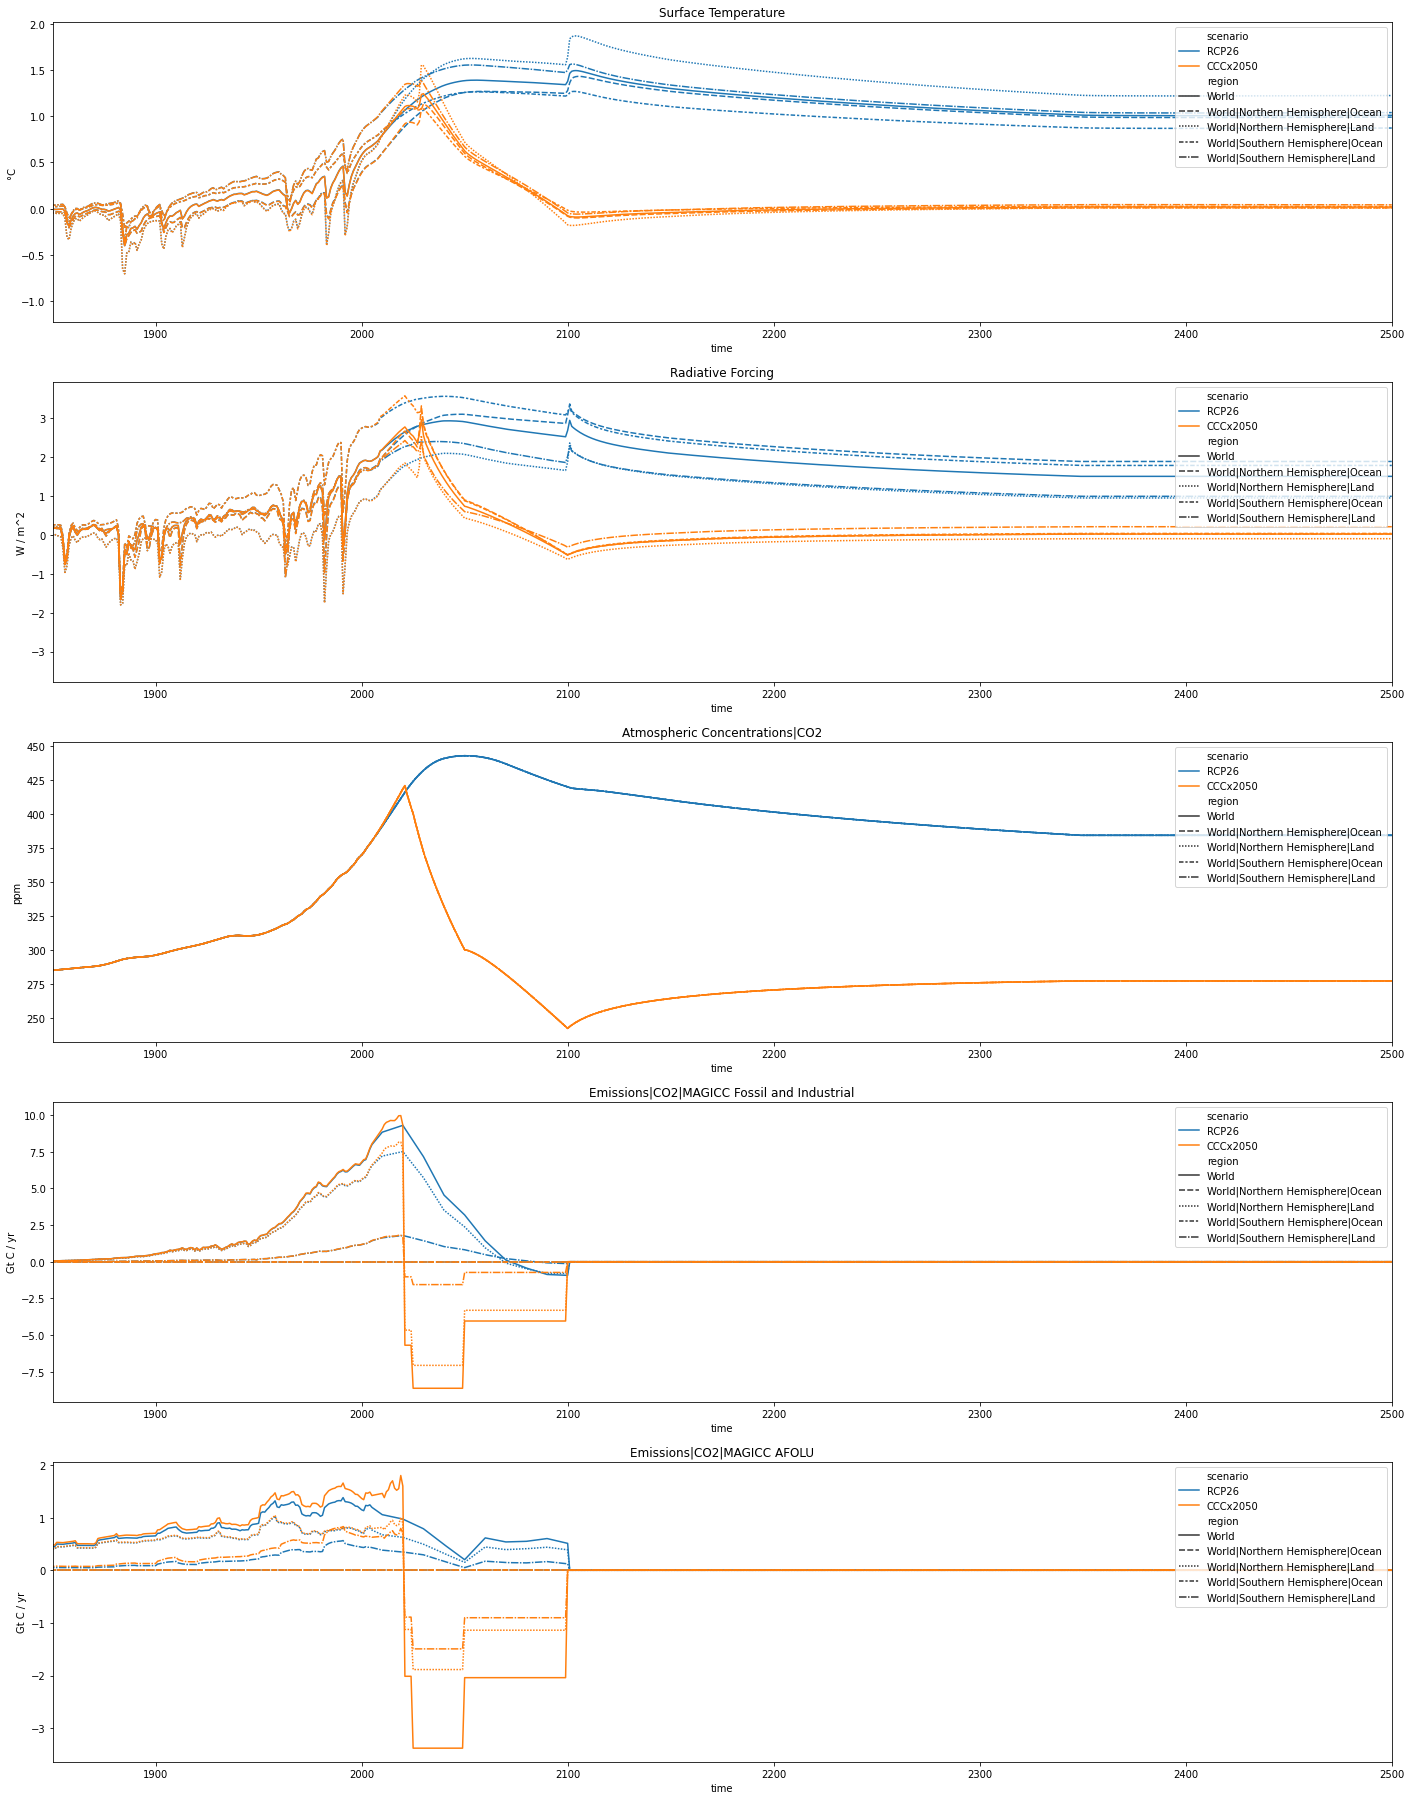

In [22]:
res = ""
%time res = pymagicc.run(rcp26, **magcfg)  #need to create res of type MAGICCData
res = meanbln(rcp26,res,**magcfg)

# Toggle to run and graph all the experiments
#declines.append(CCCxflat)
#declines.append(CCCx2050)

#for scen in declines:
#    tmprs = pymagicc.run(scen, **magcfg)
#    res = res.append(meanbln(scen, tmprs, **magcfg))
    
#for cccsn in CCCxflat,CCCx2050:
tmprs = pymagicc.run(CCCx2050, **magcfg)
res = res.append(meanbln(CCCx2050,tmprs,**magcfg))

#print(CCC_df.loc[emsf, datetime(2005,1,1,0):datetime(2020,1,1,0)].sum().max())

fig, axes = plt.subplots((len(vars)), 1, figsize=(24, 32))
for n, var in enumerate(vars):
    res.filter(variable=var).lineplot(hue="scenario", style="region", ax=axes[n])
    ylab = res.filter(variable=var)["unit"].iloc[[0]].all()
    if ylab == 'K':
        ylab = '°C'
    axes[n].set_ylabel(ylab)
    axes[n].set_title(var)                        
    axes[n].set_xlim(x)
    axes[n].legend(loc='upper right')

# Diagnostic Output

In [23]:
for dt in 2050,2100,2500:
    for var in vars,ems_ff:
        print(res.filter(variable = var,
                         region='World').timeseries().loc[:,datetime(dt,1,1)])
    for cgas in ems_ff,ems_luc:
        print("Cumulative CO₂ 1750 to", dt)
        print(res.filter(variable=cgas,
                         region='World').timeseries().loc[:,datetime(1750,1,1):datetime(dt,1,1)].sum(axis=1))

#res.filter(variable = "Atmospheric Concentrations|CO2",region="World").timeseries().loc[:,datetime(2045,1,1):datetime(2052,1,1)] >= 300
#res.filter(variable = "Atmospheric Concentrations|CO2",region="World").timeseries().loc[:,datetime(1909,1,1):datetime(1920,1,1)] >= 299

climate_model  model  region  scenario  todo          unit       variable                                  
MAGICC6        IMAGE  World   RCP26     not_relevant  ppm        Atmospheric Concentrations|CO2                442.576740
                                                      W / m^2    Radiative Forcing                               2.907523
                                                      K          Surface Temperature                             1.385382
                                                      Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial      3.185600
                                                                 Emissions|CO2|MAGICC AFOLU                      0.201200
               CDRex  World   CCCx2050  not_relevant  ppm        Atmospheric Concentrations|CO2                299.886460
                                                      W / m^2    Radiative Forcing                               0.734833
                                      

In [24]:
dfdebug2050 = res.filter(scenario="CCCx2050",region="World").timeseries().xs([
    'MAGICC6','CDRex','World','CCCx2050','not_relevant'], 
    level = ['climate_model','model','region','scenario','todo'])
newdf = dfdebug2050.loc[ (dfdebug2050[ datetime(2028,1,1,0)] < dfdebug2050[datetime(2029,1,1,0)]) & (dfdebug2050[ datetime(2028,1,1,0)] > 0)   ]
print(newdf.index.values)
newdf.loc[:,datetime(2025,1,1,0):datetime(2040,1,1,0)].sort_index().style

[('W / m^2', 'Radiative Forcing|HFC143a')
 ('ppt', 'Atmospheric Concentrations|C6F14')
 ('K', 'Surface Air Ocean Blended Temperature Change')
 ('W / m^2', 'TOTAL_INCLVOLCANIC_EFFRF') ('K', 'CLIMSENS_EFF')
 ('W / m^2', 'Radiative Forcing|N2O') ('yr', 'N2O_TAU')
 ('ppt', 'Atmospheric Concentrations|HFC143a')
 ('W / m^2', 'Radiative Forcing') ('W / m^2', 'Radiative Forcing|CF4')
 ('K', 'Surface Temperature') ('W / m^2', 'Radiative Forcing|C2F6')
 ('W / m^2', 'TOTAL_EFFRF') ('K', 'SURFACE_ANNUALMEANTEMP')
 ('W / m^2', 'Radiative Forcing|C6F14')
 ('ppt', 'Atmospheric Concentrations|C2F6')
 ('ppt', 'Atmospheric Concentrations|SF6')
 ('W / m^2', 'Radiative Forcing|SF6') ('W / m^2', 'N2O_EFFRF')
 ('ppt', 'Atmospheric Concentrations|CF4')
 ('W / m^2', 'Radiative Forcing|Anthropogenic')
 ('CO2eqppm', 'Atmospheric Concentrations|CO2 Equivalent')
 ('W / m^2', 'TOTAL_ANTHRO_EFFRF') ('K', 'SURFACE_ANNUALMEAN_MIXLTEMP')
 ('ppb', 'Atmospheric Concentrations|N2O') ('W / m^2', 'TOTAL_RF')
 ('K', 'SURFAC

The default parameters are the ones that were used to produce the RCP GHG concentrations (see also http://live.magicc.org/). Of course it's easy to change them.

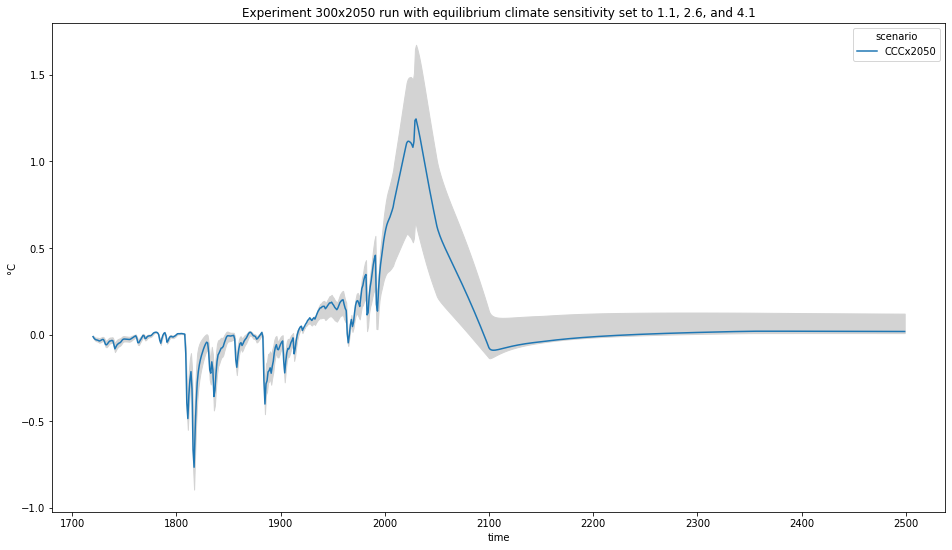

In [25]:
scenario = CCCx2050
runs = {"default":sitv, 
        "low":lsitv,
        "high":hsitv}
runsdf = {}
mcfg = magcfg.copy()

for rn in runs:
    mcfg['core_climatesensitivity'] = runs[rn]
    newrn = pymagicc.run(scenario, **mcfg)
    runsdf[rn] = meanbln(scenario, newrn, **mcfg)

filtering = {"region": "World", "variable": "Surface Temperature", 
             "year": range(1700, magcfg["endyear"])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
runsdf['default'].filter(**filtering).line_plot(x="time", ax=ax)
plt.fill_between(
    runsdf['default'].filter(**filtering)['time'],
    runsdf['low'].filter(**filtering).timeseries().values.squeeze(),
    runsdf['high'].filter(**filtering).timeseries().values.squeeze(),
    color="lightgray"
)
plt.title(
    (f"Experiment 300x2050 run with equilibrium climate sensitivity set to {lsitv}, {sitv}, and {hsitv}")
)
plt.ylabel("°C");